In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

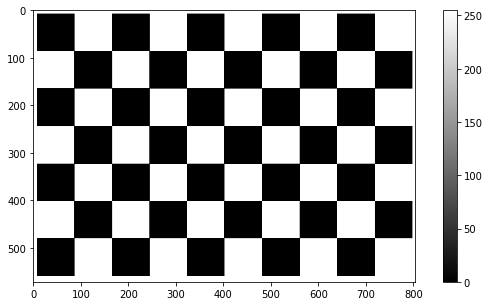

In [105]:
# fn = "/Users/ejoseph/Downloads/chessboard.png"
fn = "/Users/ejoseph/Downloads/chessboard2.png"
im = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 5)), plt.imshow(im, cmap='gray'), plt.colorbar();

## Find the chessboard

Take the derivative of the image to find the edges of the board and also to normalize the gray level.

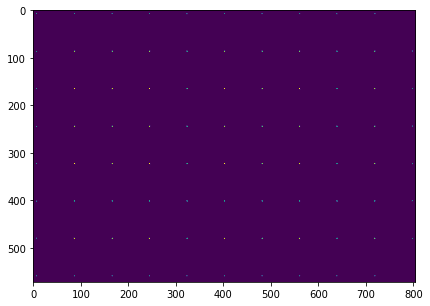

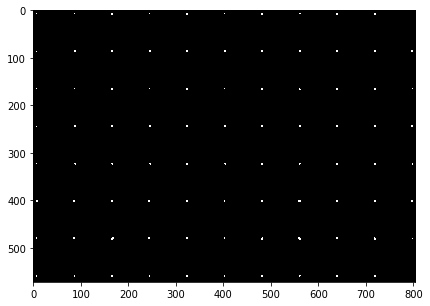

In [113]:
grid_size = (9, 6)  # Num of intersections (x, y)
im = im.astype(float)
g = cv2.Sobel(im.astype(np.float32), cv2.CV_32F, dx=1, dy=1, ksize=3)
g = np.abs(g)
bw = g > 3
plt.figure(figsize=(10, 5)), plt.imshow(g, cmap='viridis');
plt.figure(figsize=(10, 5)), plt.imshow(bw, cmap='gray');

Find the lines equation using Hough transform.
We use polar coordinates instead of the regular $y=ax+b$ to avoid numerical issues when the denominator is very small. We will represent a straight line by a rotation angle $\theta$ and the distance from the top-left corner $r$.

$x=r\cos{\theta}$

$y=r\sin{\theta}$

In [41]:
# Building a list of points
points_y, points_x = np.where(bw)
pts_xy = np.vstack((points_x, points_y)).T
pts_xy

array([[704,  18],
       [705,  18],
       [706,  18],
       ...,
       [ 10, 537],
       [ 11, 537],
       [ 13, 537]])

In [66]:
# We go over each staright line and count how many points support this line
points = np.where(bw)
r_vec = np.linspace(0, np.sqrt(im.shape[0]**2+im.shape[1]**2), 10)
theta_vec = np.linspace(0, 2*np.pi, 20)
aspect_ratio = float(im.shape[0]) / im.shape[1]
alpha = np.arctan2(im.shape[1], im.shape[0])
counts = np.zeros((len(r_vec), len(theta_vec)), dtype=int)
for i, r in enumerate(r_vec):
    for j, theta in enumerate(theta_vec):
        p0 = np.array([np.sin(alpha)*r, np.cos(alpha)*r])
        direction = np.array([np.cos(theta), np.sin(theta)])
        # find intersection with the x and y axes
        a = - p0 / direction
        # find intersection with the x-axis
        p1 = p0 + a[0]*direction
        p2 = p0 + a[1]*direction
        # [p0x,p0y]+a*[vx, vy] = [0, 0]
        print(p1, p2)
        line = np.linspace(p1[0], p2[0], 10000), np.linspace(p1[1], p2[1], 10000)
        dist = 

[0. 0.] [nan nan]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[ 0.         60.88888889] [-inf  nan]
[ 0.         31.63206305] [-9.21410518e+01 -7.10542736e-15]
[ 0.         -5.44222917] [6.99217618 0.        ]
[  0.         -69.55343291] [45.44152568  0.        ]
[   0.       -275.646056] [69.80306145  0.        ]
[-1.42108547e-14  1.08936816e+03] [90.2676194  0.       ]
[  0.         255.17598593] [111.93056518   0.        ]
[  0.         153.46490046] [141.2743931   0.       ]
[  0.         107.00884919] [197.73503414   0.        ]
[ 0.         75.10996255] [ 4.50109329e+02 -7.10542736e-15]
[ 0.         46.66781523] [-279.66488436    0.        ]
[ 0.         14.76892858] [-27.2905897   0.       ]
[  0.         -31.68712268] [29.

/Users/ejoseph/code/venvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/ejoseph/code/venvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/ejoseph/code/venvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/ejoseph/code/venvs/py36/lib/python3.6/site-packages/numpy/core/function_base.py:133: RuntimeWarning: invalid value encountered in multiply
  y *= step


In [63]:
a

array([ 7.67000000e+02, -2.23737979e+18])

In [114]:
s = 6
half_s = int(np.floor(s/ 2))
template = np.ones((s, s), dtype=np.uint8) * 255
template[:half_s, :half_s] = 0
template[half_s:, half_s:] = 0
template_neg = ~template  # the negative image
template_neg

array([[255, 255, 255,   0,   0,   0],
       [255, 255, 255,   0,   0,   0],
       [255, 255, 255,   0,   0,   0],
       [  0,   0,   0, 255, 255, 255],
       [  0,   0,   0, 255, 255, 255],
       [  0,   0,   0, 255, 255, 255]], dtype=uint8)

In [115]:
ncc = np.zeros_like(im, dtype=float)
sum2 = np.sum(template)
for i in range(s, im.shape[0] - s):
    for j in range(s, im.shape[1] - s):
        patch = im[(i-half_s):(i+half_s),(j-half_s):(j+half_s)]
        sum1 = np.sum(patch)
        ncc[i, j] = np.sum(patch * template_neg) / (sum1*sum2)

/Users/ejoseph/code/venvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


/Users/ejoseph/code/venvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x119112a58>)

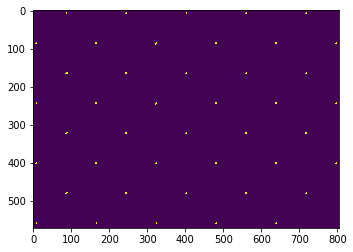

In [121]:
# plt.figure(), plt.imshow(ncc[220:270, 150:200]), plt.colorbar()
plt.figure(), plt.imshow(ncc>0.03)

## Things to consider:

- Distorted lines - problem to use Hough transform to detect straight lines. For a robust algorithm we probably need to look on local features.

In [80]:
s2 = np.sum(template)
s2

4590